In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from scipy.stats import chi2

## Parameter Settings

In [2]:
mat = scipy.io.loadmat('Data/hw6data.mat')

In [3]:
cov = mat['Q']
mu = mat['mu'].reshape(-1)
rtn_series = mat['R']

In [4]:
sample_mean = np.mean(rtn_series,axis = 1)
sample_cov = np.cov(rtn_series)

## Conduct Optimization and Draw Frontier Plot

In [11]:
def build_frontier(true_return, true_cov, estimated_return, sigma, risk_level, eta):
    
    N_asset = len(true_return)
    L = np.linalg.cholesky(true_cov)
    
    #Calculate true frontier
    c = matrix((-1)*true_return)
    A = matrix(np.array([[1.0 for i in range(N_asset)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset)]), tc='d')
    Gq = [matrix(np.vstack([np.array([0.0 for i in range(N_asset)]), (-1)*L.T]))]
    hq = [matrix(np.array([risk_level] + [0.0 for i in range(N_asset)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_true = sol['x']
    
    r_true = -sol['primal objective']
    
    #Calculate estimated Markowitz frontier
    c = matrix((-1)*estimated_return)
    A = matrix(np.array([[1.0 for i in range(N_asset)]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset)]), tc='d')
    Gq = [matrix(np.vstack([np.array([0.0 for i in range(N_asset)]), (-1)*L.T]))]
    hq = [matrix(np.array([risk_level] + [0.0 for i in range(N_asset)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_estimated = sol['x']
    
    r_estimated = -sol['primal objective']
    
    #Calculate Actual Markowitz frontier
    r_actual = np.dot(true_return, w_estimated)[0]
    
    #Calculate Estimated Robust frontier
    kappa = np.sqrt(chi2.ppf(eta, df = N_asset))
    P = np.linalg.cholesky(sigma)
    
    c = matrix(np.append((-1)*estimated_return, [kappa]))
    A = matrix(np.array([[1.0 for i in range(N_asset)] + [0.0]]), tc='d')
    b = matrix(np.array([1.0]), tc='d')
    
    Gl = matrix(np.diag([-1.0 for i in range(N_asset+1)]), tc='d')
    hl = matrix(np.array([0.0 for i in range(N_asset+1)]), tc='d')
    G_0 = np.hstack([(-1)*L.T, np.array([[0.0] for i in range(N_asset)])])
    G_0 = np.vstack([np.array([0.0 for i in range(N_asset+1)]), G_0])
    Gq = [matrix(G_0)]
    hq = [matrix(np.array([risk_level] + [0.0 for i in range(N_asset)]))]
    G_1 = np.hstack([(-1)*P.T, np.array([[0.0] for i in range(N_asset)])])
    G_1 = np.vstack([np.array([0.0 for i in range(N_asset)] + [-1.0]), G_1])
    Gq += [matrix(G_1)]
    hq += [matrix(np.array([0.0 for i in range(N_asset+1)]))]
    
    sol = solvers.socp(c, Gl = Gl, hl = hl, Gq = Gq, hq = hq, A = A, b = b)
    w_estimated_robust = sol['x'][:-1]
    
    r_estimated_robust= np.dot(estimated_return, w_estimated_robust)[0]
    
    #Calculate Actual Markowitz frontier
    r_actual_robust = np.dot(true_return, w_estimated_robust)[0]
    
    return (w_true, w_estimated, w_estimated_robust, 
            r_true, r_estimated, r_actual, r_estimated_robust, r_actual_robust)

In [16]:
risk_levels = np.arange(0.05, 0.4, 0.002)
frontier = pd.DataFrame(data = None, index = [risk for risk in risk_levels],
                        columns = ['true frontier', 'estimated frontier', 'actual frontier',
                                   'estimated robust frontier', 'actual robust frontier'])

for risk in risk_levels:
    results = build_frontier(true_return = mu, true_cov = cov, estimated_return = sample_mean, 
             sigma = np.diag(np.diag(cov/len(rtn_series[0]))), risk_level = risk, eta = 0.99)
    frontier.loc[risk] = [results[i] for i in range(3,8)]

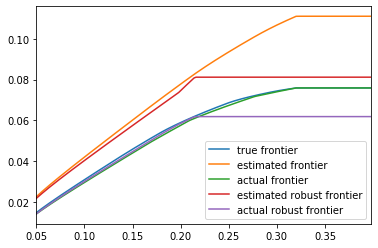

In [17]:
frontier.plot()